# Research Question 3

## Introduction
Can we classify whether a given week’s sales (across all stores) will be above or below the average, using only general predictors like fuel price, CPI, unemployment, and holiday flags?

**Hypothesis:** Weekly sales can be reliably categorized as “high” or “low” using classification models with predictors like fuel price, CPI, unemployment, and holiday flags.

Early on we discovered by looking at the correlation matrix in our DataWrangling notebook that Weekly_Sales had an incredible weak linear correlation to any of the other columns in the dataset, except for the Store id column. We thought it could possibly give some insights on the data if we tried to use a non-linear approach like Classification.

It should be noted that classification is not typically used to predict continuous values like Weekly_Sales so as the research question says, we'll be focusing on predicting whether 

## Data Ingestion

In [7008]:
import pandas as pd
import numpy as np

# matplotlib.pyplot for data plots
import matplotlib.pyplot as plt

import seaborn as sns

In [7009]:
# Load dataset
df = pd.read_csv('../Data/Walmart_Sales.csv')

In [7010]:
df.columns

c:\Users\mixmo\anaconda3\Lib\site-packages\IPython\core\displayhook.py:281: UserWarning: Output cache limit (currently 1000 entries) hit.
Flushing oldest 200 entries.
  warn('Output cache limit (currently {sz} entries) hit.\n'


Index(['Store', 'Date', 'Weekly_Sales', 'Holiday_Flag', 'Temperature',
       'Fuel_Price', 'CPI', 'Unemployment'],
      dtype='object')

In [7011]:
df.shape

(6435, 8)

In [7012]:
df.describe()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,6435.000000,6.435000e+03,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000
mean,23.000000,1.046965e+06,0.069930,60.663782,3.358607,171.578394,7.999151
std,12.988182,5.643666e+05,0.255049,18.444933,0.459020,39.356712,1.875885
min,1.000000,2.099862e+05,0.000000,-2.060000,2.472000,126.064000,3.879000
25%,12.000000,5.533501e+05,0.000000,47.460000,2.933000,131.735000,6.891000
50%,23.000000,9.607460e+05,0.000000,62.670000,3.445000,182.616521,7.874000
75%,34.000000,1.420159e+06,0.000000,74.940000,3.735000,212.743293,8.622000
max,45.000000,3.818686e+06,1.000000,100.140000,4.468000,227.232807,14.313000


In [7013]:
df.isnull().sum()

Store           0
Date            0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
dtype: int64

In [7014]:
df.duplicated().sum()

0

In [7015]:
df.sample(5)

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
3494,25,15-04-2011,674562.45,0,51.43,3.821,208.317281,7.287
357,3,17-06-2011,403423.34,0,86.96,3.637,218.355175,7.574
3587,26,30-04-2010,904503.85,0,40.56,2.935,132.064433,8.512
5600,40,16-07-2010,959229.09,0,74.25,2.796,132.566774,5.326
2130,15,20-07-2012,592369.22,0,75.31,3.732,138.233193,8.193


### Data Cleaning

In [7016]:
df.drop(['Store'], axis=1, inplace=True)

In [7017]:
# Convert date column to datetime
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')

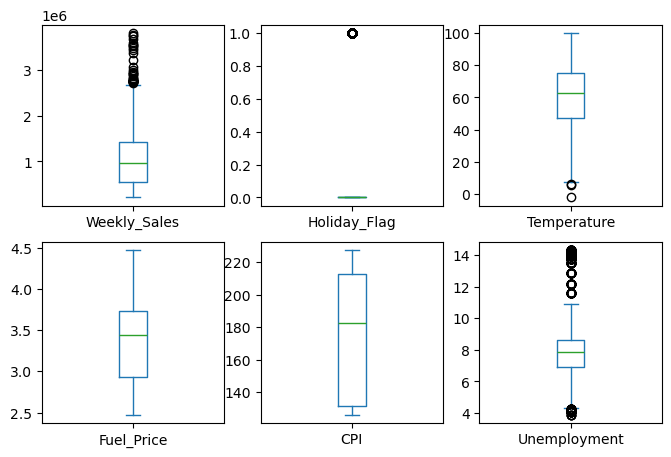

In [7018]:
# Draw box-whisker plots
df.plot(kind='box', subplots=True, layout=(3, 3), figsize=(8, 8), sharex=False, sharey=False)
plt.show()

In [7019]:
import pandas as pd

def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    non_outlier_mask = (df[column] >= lower_bound) & (df[column] <= upper_bound)
    outliers = df[~non_outlier_mask]
    df_clean = df[non_outlier_mask]

    print(f"Number of outliers to be removed from '{column}': {len(outliers)}")
    print(f"Remaining rows: {len(df_clean)}")

    return df

In [7020]:
df = remove_outliers(df, 'Weekly_Sales')
df = remove_outliers(df, 'Temperature')
df = remove_outliers(df, 'Unemployment')

Number of outliers to be removed from 'Weekly_Sales': 34
Remaining rows: 6401
Number of outliers to be removed from 'Temperature': 3
Remaining rows: 6432
Number of outliers to be removed from 'Unemployment': 481
Remaining rows: 5954


In [7021]:
df.sample(5)

,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
3519,2011-10-07,671522.87,0,50.82,3.583,210.117060,7.082
932,2011-07-08,761793.94,0,59.08,3.540,193.187845,8.622
6401,2012-03-09,776968.87,0,45.52,3.848,190.335997,8.424
2217,2011-06-24,569105.03,0,54.36,3.661,192.998266,6.339
2990,2012-08-03,693785.85,0,91.57,3.417,221.586980,6.565


An attempt was made to extract the __Season__ from the date but this did not yield any improvements to the models. It was found that the newly created Season column had a feature importance of exactly 0 meaning it didn't have any impact.

In [7022]:
from sklearn.preprocessing import LabelEncoder

labelEncoder = LabelEncoder()

# Correcting the date format
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Quarter'] = df['Date'].dt.quarter
df['Week'] = df['Date'].dt.isocalendar().week

df.drop(['Date'], axis=1, inplace=True)

## Feature Engineering

In [7023]:
# Create the target column: 1 if weekly sales are above average, else 0
mean_sales = df['Weekly_Sales'].mean()
df['High_Sales'] = (df['Weekly_Sales'] > mean_sales).astype(int)

df.drop(['Weekly_Sales'], axis=1, inplace=True)

In [7024]:
df.head()

,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Year,Month,Quarter,Week,High_Sales
0,0,42.31,2.572,211.096358,8.106,2010,2,1,5,1
1,1,38.51,2.548,211.242170,8.106,2010,2,1,6,1
2,0,39.93,2.514,211.289143,8.106,2010,2,1,7,1
3,0,46.63,2.561,211.319643,8.106,2010,2,1,8,1
4,0,46.50,2.625,211.350143,8.106,2010,3,1,9,1


## Feature Selection

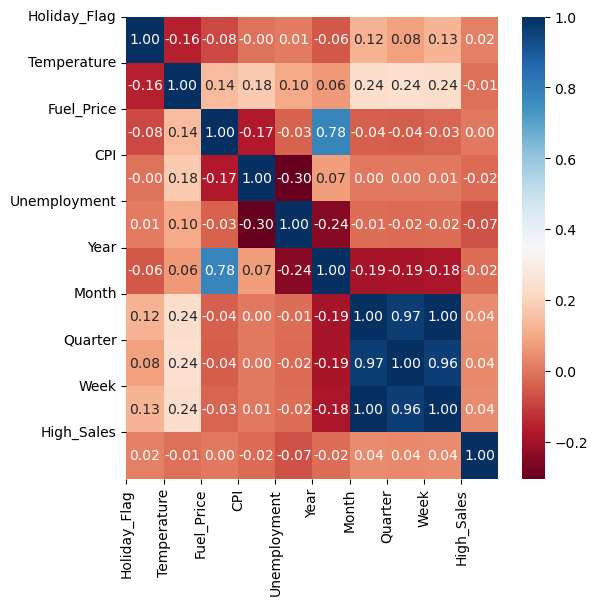

In [7025]:
numeric_columns = df.select_dtypes(include=np.number).columns.tolist()
corr = df[numeric_columns].corr(method='pearson')

fig, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(corr, cmap='RdBu', annot=True, fmt=".2f")
plt.xticks(range(len(corr.columns)), corr.columns)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.show()

Drop the unnecessary Date columns

In [7026]:
#df = df.drop(['Fuel_Price'], axis=1)

In [7027]:
df.sample(5)

,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Year,Month,Quarter,Week,High_Sales
4155,0,64.12,2.719,210.479887,8.200,2010,4,2,13,0
1652,0,91.04,3.701,129.201581,13.503,2011,8,3,32,0
1256,0,67.87,3.845,225.107867,5.667,2012,3,1,13,0
113,0,70.43,3.891,221.435611,7.143,2012,4,2,14,1
5796,0,74.11,3.545,193.512037,6.901,2011,7,3,29,1


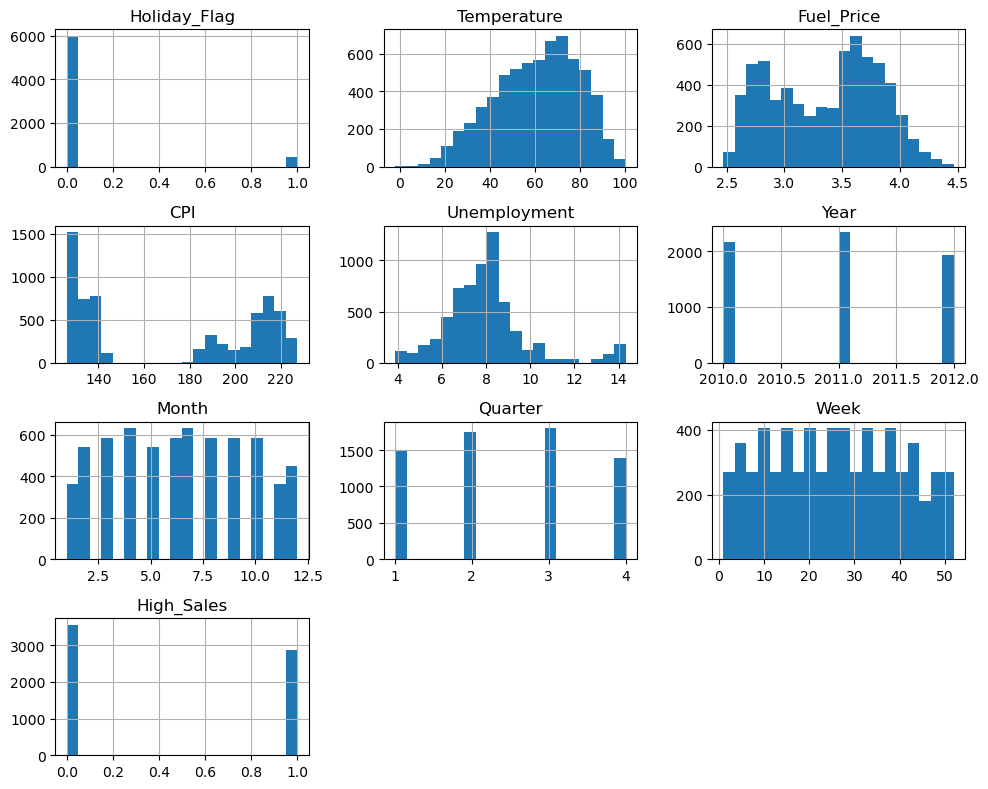

In [7028]:
df.hist(bins=20, figsize=(10, 8))
plt.tight_layout()
plt.show()

## Scaling

In [7029]:
X = df.drop('High_Sales', axis=1)
y = df['High_Sales']

The StandardScaler is applied to columns that are normally distributed.

In [7030]:
from sklearn.preprocessing import StandardScaler

standardScaler = StandardScaler()  

features_norm = ['Temperature', 'Unemployment']

X_norm = standardScaler.fit_transform(X[features_norm])
X_norm = pd.DataFrame(X_norm, columns=features_norm)
X_norm.head()

,Temperature,Unemployment
0,-0.995136,0.056964
1,-1.201170,0.056964
2,-1.124178,0.056964
3,-0.760907,0.056964
4,-0.767955,0.056964


Here the MinMaxScaler is used instead for columns that are not normally distributed.

In [7031]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

features_non_norm = [col for col in X.columns if col not in features_norm]

X_non_norm = scaler.fit_transform(X[features_non_norm])
X_non_norm = pd.DataFrame(X_non_norm, columns=features_non_norm)
X_non_norm.head()

,Holiday_Flag,Fuel_Price,CPI,Year,Month,Quarter,Week
0,0.0,0.050100,0.840500,0.0,0.090909,0.0,0.078431
1,1.0,0.038076,0.841941,0.0,0.090909,0.0,0.098039
2,0.0,0.021042,0.842405,0.0,0.090909,0.0,0.117647
3,0.0,0.044589,0.842707,0.0,0.090909,0.0,0.137255
4,0.0,0.076653,0.843008,0.0,0.181818,0.0,0.156863


In [7032]:
X = pd.concat([X_non_norm, X_norm], axis=1)
X.head()

,Holiday_Flag,Fuel_Price,CPI,Year,Month,Quarter,Week,Temperature,Unemployment
0,0.0,0.050100,0.840500,0.0,0.090909,0.0,0.078431,-0.995136,0.056964
1,1.0,0.038076,0.841941,0.0,0.090909,0.0,0.098039,-1.201170,0.056964
2,0.0,0.021042,0.842405,0.0,0.090909,0.0,0.117647,-1.124178,0.056964
3,0.0,0.044589,0.842707,0.0,0.090909,0.0,0.137255,-0.760907,0.056964
4,0.0,0.076653,0.843008,0.0,0.181818,0.0,0.156863,-0.767955,0.056964


## Training

In [7033]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

Through experimentation it was found that the best to split the set into 0.2% for test.

In [7034]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7035]:
print('Shape of X_train: ', X_train.shape)
print('Shape of X_test: ', X_test.shape)
print('Shape of y_train: ', y_train.shape)
print('Shape of y_test: ', y_test.shape)

Shape of X_train:  (5148, 9)
Shape of X_test:  (1287, 9)
Shape of y_train:  (5148,)
Shape of y_test:  (1287,)


Through experimentation it was found that a max_depth of 12 gave the best results.

In [7036]:
from sklearn.tree import DecisionTreeClassifier

decisionTreeClassifier = DecisionTreeClassifier(max_depth=10, random_state=42)
decisionTreeClassifier.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=10, random_state=42)

In [7037]:
y_pred = decisionTreeClassifier.predict(X_test)
y_acc_score = accuracy_score(y_test, y_pred)

print("Accuracy: {0:.2f}%".format(y_acc_score * 100))
print(classification_report(y_test, y_pred))

Accuracy: 65.58%
              precision    recall  f1-score   support

           0       0.70      0.65      0.67       702
           1       0.61      0.67      0.64       585

    accuracy                           0.66      1287
   macro avg       0.66      0.66      0.65      1287
weighted avg       0.66      0.66      0.66      1287



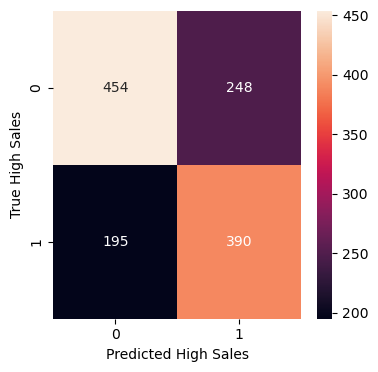

In [7038]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt='.0f')
plt.xlabel("Predicted High Sales")
plt.ylabel("True High Sales")
plt.show()

In [7039]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(decisionTreeClassifier, X, y, cv=5)
print("Cross-validation scores:", cv_scores)
print("Mean CV accuracy: {:.2f}%".format(cv_scores.mean() * 100))

Cross-validation scores: [0.1958042  0.1950272  0.3954934  0.31313131 0.14219114]
Mean CV accuracy: 24.83%


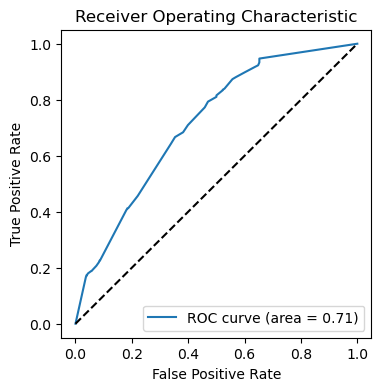

In [7040]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_proba = decisionTreeClassifier.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(4, 4))
plt.plot(fpr, tpr, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [7041]:
importances = decisionTreeClassifier.feature_importances_
for feature, importance in zip(X_test.columns, importances):
    print(f"{feature}: {importance:.2f}")

Holiday_Flag: 0.00
Fuel_Price: 0.05
CPI: 0.22
Year: 0.08
Month: 0.01
Quarter: 0.01
Week: 0.06
Temperature: 0.11
Unemployment: 0.45


In [7042]:
train_acc = decisionTreeClassifier.score(X_train, y_train)
test_acc = decisionTreeClassifier.score(X_test, y_test)
print(f"Train Accuracy: {train_acc:.2f}")
print(f"Test Accuracy: {test_acc:.2f}")

Train Accuracy: 0.72
Test Accuracy: 0.66


In [7043]:
from sklearn.ensemble import RandomForestClassifier

randomForestClassifier = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
randomForestClassifier.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, random_state=42)

In [7044]:
y_pred = randomForestClassifier.predict(X_test)
y_acc_score = accuracy_score(y_test, y_pred)

print("Accuracy: {0:.2f}%".format(y_acc_score * 100))
print(classification_report(y_test, y_pred))

Accuracy: 63.95%
              precision    recall  f1-score   support

           0       0.68      0.64      0.66       702
           1       0.60      0.64      0.62       585

    accuracy                           0.64      1287
   macro avg       0.64      0.64      0.64      1287
weighted avg       0.64      0.64      0.64      1287



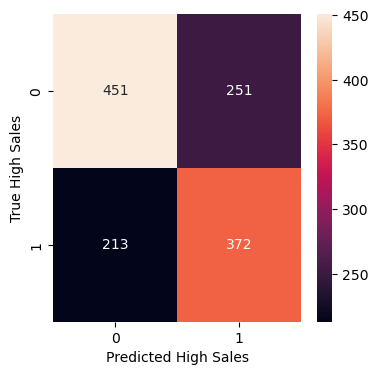

In [7045]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt='.0f')
plt.xlabel("Predicted High Sales")
plt.ylabel("True High Sales")
plt.show()

In [7046]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(randomForestClassifier, X, y, cv=5)
print("Cross-validation scores:", cv_scores)
print("Mean CV accuracy: {:.2f}%".format(cv_scores.mean() * 100))

Cross-validation scores: [0.19114219 0.14296814 0.42501943 0.39160839 0.18648019]
Mean CV accuracy: 26.74%


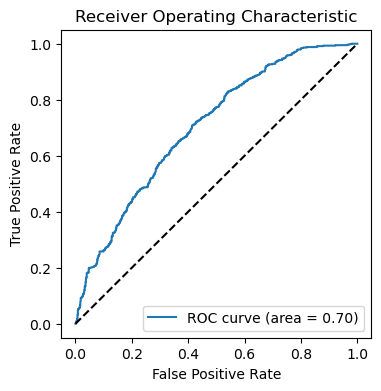

In [7047]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_proba = randomForestClassifier.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(4, 4))
plt.plot(fpr, tpr, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [7048]:
importances = randomForestClassifier.feature_importances_
for feature, importance in zip(X_test.columns, importances):
    print(f"{feature}: {importance:.2f}")

Holiday_Flag: 0.01
Fuel_Price: 0.11
CPI: 0.19
Year: 0.03
Month: 0.03
Quarter: 0.01
Week: 0.08
Temperature: 0.16
Unemployment: 0.39


In [7049]:
train_acc = randomForestClassifier.score(X_train, y_train)
test_acc = randomForestClassifier.score(X_test, y_test)
print(f"Train Accuracy: {train_acc:.2f}")
print(f"Test Accuracy: {test_acc:.2f}")

Train Accuracy: 0.79
Test Accuracy: 0.64


In [7050]:
from sklearn.naive_bayes import GaussianNB

bayers = GaussianNB()
bayers.fit(X_train, y_train)

GaussianNB()

In [7051]:
y_pred = bayers.predict(X_test)
y_acc_score = accuracy_score(y_test, y_pred)

print("Accuracy: {0:.2f}%".format(y_acc_score * 100))
print("Score: {0:.2f}%".format(bayers.score(X_test, y_test) * 100))
print(classification_report(y_test, y_pred))

Accuracy: 54.70%
Score: 54.70%
              precision    recall  f1-score   support

           0       0.56      0.77      0.65       702
           1       0.50      0.28      0.36       585

    accuracy                           0.55      1287
   macro avg       0.53      0.52      0.50      1287
weighted avg       0.54      0.55      0.52      1287



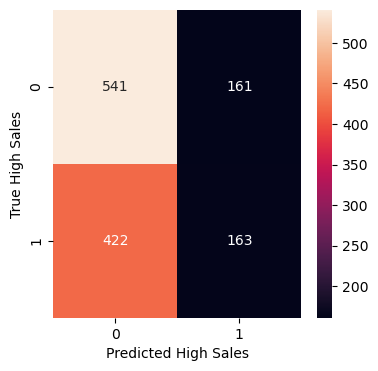

In [7052]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt='.0f')
plt.xlabel("Predicted High Sales")
plt.ylabel("True High Sales")
plt.show()

## Validation

In [7053]:
X_test

,Holiday_Flag,Fuel_Price,CPI,Year,Month,Quarter,Week,Temperature,Unemployment
2436,0.0,0.166834,0.056539,0.0,0.181818,0.000000,0.176471,-0.990798,0.641267
3361,0.0,0.747495,0.090950,0.5,0.454545,0.333333,0.470588,0.445480,0.113475
233,0.0,0.450902,0.902068,0.5,0.818182,1.000000,0.823529,0.282279,-0.297563
3667,0.0,0.550100,0.102777,0.5,0.909091,1.000000,0.862745,-1.116045,-0.213863
5011,0.0,0.114729,0.829468,0.0,0.181818,0.000000,0.196078,-0.059847,0.295803
...,...,...,...,...,...,...,...,...,...
2600,0.0,0.235471,0.064745,0.0,0.636364,0.666667,0.588235,0.733929,0.053232
6308,0.0,0.213928,0.553357,0.0,0.363636,0.333333,0.392157,0.466626,0.479730
6292,0.0,0.156313,0.551624,0.0,0.090909,0.000000,0.078431,-1.808430,0.529311
151,0.0,0.123747,0.834406,0.0,0.272727,0.333333,0.235294,0.141308,0.107077


In [7054]:
y_pred = decisionTreeClassifier.predict(X_test)
y_pred.shape

(1287,)

In [7055]:
y_pred[:50]

array([1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1,
       0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 1])

In [7056]:
y_test.values[:50]

array([1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1,
       1, 0, 1, 0, 1, 0])

## Store the model for possible later use

In [7057]:
import joblib

In [7058]:
# Store the model in a file
model_file = '../Data/DecisionTreeClassifier.pkl'

In [7059]:
# save the model
joblib.dump(decisionTreeClassifier, model_file)

['../Data/DecisionTreeClassifier.pkl']